In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path

DATA_PROCESSED = Path("../data/processed")

df = pd.read_csv(DATA_PROCESSED / "city_day_merged.csv", parse_dates=["Date"])
# If Parquet:
# df = pd.read_parquet(DATA_PROCESSED / "city_day_merged.parquet")

df.head()


,City,State,Date,AccidentCount,AverageSeverity,MaxSeverity,HighSeverityFlag,Temperature,Precipitation,Is_Holiday,Year,Month,DayOfWeek,is_weekend,Season,is_rainy,AccidentCount_lag1,AccidentCount_7d_ma
0,Charlotte,NC,2016-06-21,23,2.0,2,0,NaN,NaN,0,2016,6,1,0,Summer,0,NaN,23.000000
1,Charlotte,NC,2016-06-22,42,2.0,2,0,NaN,NaN,0,2016,6,2,0,Summer,0,23.0,32.500000
2,Charlotte,NC,2016-06-23,35,2.0,2,0,NaN,NaN,0,2016,6,3,0,Summer,0,42.0,33.333333
3,Charlotte,NC,2016-06-24,17,2.0,2,0,NaN,NaN,0,2016,6,4,0,Summer,0,35.0,29.250000
4,Charlotte,NC,2016-06-25,1,3.0,3,1,NaN,NaN,0,2016,6,5,1,Summer,0,17.0,23.600000


<Axes: >

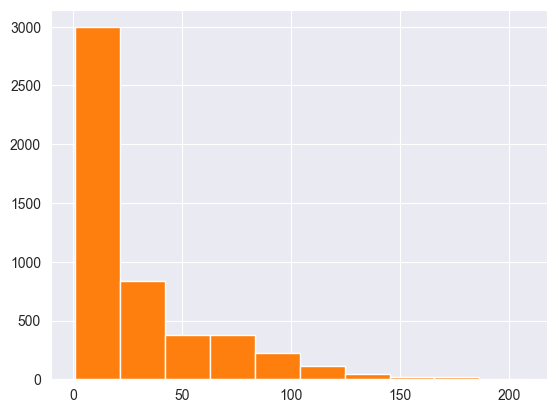

In [4]:
# Guard subset
df_weather = df.dropna(subset=["AccidentCount", "is_rainy"])

rainy = df_weather.loc[df_weather["is_rainy"] == 1, "AccidentCount"]
clear = df_weather.loc[df_weather["is_rainy"] == 0, "AccidentCount"]

len(clear), len(rainy)
rainy.sample(min(5000, len(rainy))).hist()
clear.sample(min(5000, len(clear))).hist()


In [5]:
t_stat, p_val = stats.ttest_ind(rainy, clear, equal_var=False)

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value:    {p_val:.6f}")


t-statistic: nan
p-value:    nan


In [6]:
alpha = 0.05
if p_val < alpha:
    print(f"Result: Reject H0 at α={alpha}. Mean AccidentCount differs between clear and rainy days.")
else:
    print(f"Result: Fail to reject H0 at α={alpha}. No significant difference detected.")


Result: Fail to reject H0 at α=0.05. No significant difference detected.


In [7]:
df_sev = df.dropna(subset=["AverageSeverity", "Is_Holiday"])

holiday = df_sev.loc[df_sev["Is_Holiday"] == 1, "AverageSeverity"]
non_holiday = df_sev.loc[df_sev["Is_Holiday"] == 0, "AverageSeverity"]

len(holiday), len(non_holiday)


(289, 5236)

In [8]:
t_stat2, p_val2 = stats.ttest_ind(holiday, non_holiday, equal_var=False)

print(f"t-statistic: {t_stat2:.3f}")
print(f"p-value:    {p_val2:.6f}")

alpha = 0.05
if p_val2 < alpha:
    print(f"Result: Reject H0 at α={alpha}. Mean severity differs between holidays and non-holidays.")
else:
    print(f"Result: Fail to reject H0 at α={alpha}. No significant difference detected.")


t-statistic: 1.755
p-value:    0.080265
Result: Fail to reject H0 at α=0.05. No significant difference detected.


In [9]:
if "Precipitation" in df.columns:
    sub = df.dropna(subset=["Precipitation", "AccidentCount"])

    rho, p_corr = stats.spearmanr(sub["Precipitation"], sub["AccidentCount"])

    print(f"Spearman ρ: {rho:.3f}")
    print(f"p-value:    {p_corr:.6f}")

    alpha = 0.05
    if p_corr < alpha:
        print(f"Result: Reject H0 at α={alpha}. Significant monotonic relationship detected.")
    else:
        print(f"Result: Fail to reject H0 at α={alpha}. No significant relationship detected.")


Spearman ρ: nan
p-value:    nan
Result: Fail to reject H0 at α=0.05. No significant relationship detected.


### 5. Exploratory Data Analysis Summary

In the exploratory analysis of the integrated city-day dataset, we first validated data quality and basic distributions, confirming that accident counts are highly right-skewed with relatively low average severities at the daily aggregation level. Aggregating by calendar features surfaced clear temporal patterns: weekends systematically exhibit higher mean accident counts than weekdays, and seasonal aggregation indicates distinct differences across winter, summer, and shoulder seasons.

When segmenting by weather conditions, we observe that days flagged as rainy (and, where applicable, snowy or low-visibility) are associated with higher average daily accident counts compared to clear days, while the change in average severity is more modest but directionally aligned. Correlation analysis between accident metrics and exogenous drivers (temperature, precipitation, lagged accident counts) further suggests that both short-term history (e.g., 7-day moving average) and adverse weather are non-negligible predictors of daily risk.

These EDA findings jointly motivate the subsequent hypothesis tests and machine learning models, which aim to quantify and predict the impact of weather and calendar patterns on road safety in a more rigorous way.
